In [1]:
import numpy as np
import pandas as pd
import csv
import string

In [16]:
#data frame download
import re
file_path = 'shot_logs.csv'
dtype_dict ={'GAME_ID': int, 'MATCHUP': str, 'LOCATION': str, 'W': str, 'FINAL_MARGIN': int, 
                         'SHOT_NUMBER': int, 'PERIOD': int, 'GAME_CLOCK': str, 'SHOT_CLOCK': str, 
                         'DRIBBLES': int, 'TOUCH_TIME': float, 'SHOT_DIST': float, 'PTS_TYPE': int, 
                         'SHOT_RESULT': str, 'CLOSEST_DEFENDER': str, 'CLOSEST_DEFENDER_PLAYER_ID': int, 
                         'CLOSE_DEF_DIST': float, 'FGM': int, 'PTS': int, 'player_name': str, 'player_id': int}
df = pd.read_csv(file_path, sep=",", dtype=dtype_dict)

In [17]:
#data cleanse
def split_date_and_matchup(date_str):
    # Extract the date part using regex
    date_match = re.search(r'\b\w{3} \d{2}, \d{4}\b', date_str)
    if date_match:
        # Extract date and convert to YYYY-MM-DD format
        date = pd.to_datetime(date_match.group(0), format='%b %d, %Y').strftime('%Y-%m-%d')
        # Extract matchup string by removing the date part and the separator
        matchup = date_str.replace(date_match.group(0) + ' - ', '')
        return pd.Series([date, matchup])
    else:
        return pd.Series([None, None])
df[['DATE', 'MATCHUP']] = df['MATCHUP'].apply(split_date_and_matchup)
def clean_data(df):
    #sets shot_result to binary results
    df['SHOT_RESULT'] = df['SHOT_RESULT'].map({'made': 1, 'missed' : 0})
    #remove unrealistic times
    df.loc[df['TOUCH_TIME'] < 0, 'TOUCH_TIME'] = np.nan
    #drop NULL results
    df = df.dropna()
clean_data(df)


In [18]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 128069 entries, 0 to 128068
Data columns (total 22 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   GAME_ID                     128069 non-null  int64  
 1   MATCHUP                     128069 non-null  object 
 2   LOCATION                    128069 non-null  object 
 3   W                           128069 non-null  object 
 4   FINAL_MARGIN                128069 non-null  int64  
 5   SHOT_NUMBER                 128069 non-null  int64  
 6   PERIOD                      128069 non-null  int64  
 7   GAME_CLOCK                  128069 non-null  object 
 8   SHOT_CLOCK                  122502 non-null  object 
 9   DRIBBLES                    128069 non-null  int64  
 10  TOUCH_TIME                  127757 non-null  float64
 11  SHOT_DIST                   128069 non-null  float64
 12  PTS_TYPE                    128069 non-null  int64  
 13  SHOT_RESULT   

In [22]:
#input player name
def player_input():
    #takes player input for name
    p_first = input("Enter the player's first name: (ex. 'james')")
    p_last = input("Enter the player's last name: (ex. 'harden)")
    #remove any accidental white spaces, making it uniform
    p_first = p_first.strip().lower()
    p_last = p_last.strip().lower()
    player_name = p_first + " " + p_last
    #keep requesting input until correct
    if not(player_name in df['player_name'].values):
        print("Error: Name could not be found. Player will be defaulted to Stephen Curry")
        player_name = 'stephen curry'
    #creates df of singular player
    player_df = df[df['player_name'] == player_name]
    return player_df, player_name


#total shooting percentage
def total_shots(player_df):
    #gets total shots dependent on length of df
    tot_shots = len(player_df)
    print(tot_shots)
    made_shots = (player_df['FGM'] == 1).sum()
    tot_shot_pct = made_shots / tot_shots
    return tot_shot_pct

#print(player_df.head())
#2 pt shooting_percentage
def total_2pt_shots(player_df):
    #isolates players shots dependent on point type
    tot_2pt_shots = (player_df['PTS_TYPE'] == 2).sum()
    made_2pt_shots = ((player_df['FGM'] == 1) & (player_df['PTS_TYPE'] == 2)).sum()
    tot_2pt_shot_pct = made_2pt_shots / tot_2pt_shots
    return tot_2pt_shot_pct

#3 pt shooting_percentage
def total_3pt_shots(player_df):
    #isolates players shots dependent on point type
    tot_3pt_shots = (player_df['PTS_TYPE'] == 3).sum()
    made_3pt_shots = ((player_df['FGM'] == 1) & (player_df['PTS_TYPE'] == 3)).sum()
    tot_3pt_shot_pct = made_3pt_shots / tot_3pt_shots
    return tot_3pt_shot_pct

#Best Matchup
def best_worst_matchup(player_df):
    #create list of all defenders that guarded specific player
    defenders = player_df['CLOSEST_DEFENDER'].tolist()
    defender_pct = {}
    for defender in defenders:
        tot_per_def = (player_df['CLOSEST_DEFENDER'] == defender).sum()
        if (tot_per_def >= 10):
            made_per_def = ((player_df['CLOSEST_DEFENDER'] == defender) & (player_df['FGM'] == 1)).sum()
            defender_pct[defender] = made_per_def / tot_per_def
    
    best = max(defender_pct, key=lambda k: defender_pct[k])
    best_pct = defender_pct[best]
    #Worst Matchup
    worst = min(defender_pct, key=lambda k: defender_pct[k])
    worst_pct = defender_pct[worst]
    return best, best_pct, worst, worst_pct

#wide open based off 2k
def wide_open(player_df):
    wide_open_df =  player_df[player_df['CLOSE_DEF_DIST'] >=  4]
    wide_open_makes = (wide_open_df['FGM'] == 1).sum()
    tot_wide_open = len(wide_open_df)
    wide_open_pct = wide_open_makes / tot_wide_open
    return wide_open_pct

#open/contested
def contested(player_df):
    contested_df =  player_df[player_df['CLOSE_DEF_DIST'] <  4]
    contested_makes = (contested_df['FGM'] ==  1).sum()
    tot = len(contested_df)
    contested_pct = contested_makes / tot
    return contested_pct

def wide_open_3pt(player_df):
    wide_open_df =  player_df[player_df['CLOSE_DEF_DIST'] >=  4]
    wide_open_makes = ((wide_open_df['FGM'] == 1) & (wide_open_df['PTS_TYPE'] == 3)).sum()
    tot_wide_open = len(wide_open_df)
    wide_open_3pct = wide_open_makes / tot_wide_open
    return wide_open_3pct

#open/contested
def contested_3pt(player_df):
    contested_df =  player_df[player_df['CLOSE_DEF_DIST'] <  4]
    contested_makes = (contested_df['FGM'] ==  1).sum()
    tot = len(contested_df)
    contested_pct = contested_makes / tot
    return contested_pct

#print statements
player_df, player_name = player_input()
tot_shot_pct = total_shots(player_df)
tot_2pt_shot_pct = total_2pt_shots(player_df)
tot_3pt_shot_pct = total_3pt_shots(player_df)
best_matchup, best_pct, worst_matchup, worst_pct = best_worst_matchup(player_df)
wide_open_pct = wide_open(player_df)
wide_open_3pct = wide_open_3pt(player_df)
contested_pct = contested(player_df)
print(string.capwords(player_name, sep=None))
print('Shooting Percentage: ', tot_shot_pct)
print('2pt Shooting Percentage: ', tot_2pt_shot_pct)
print('3pt Shooting Percentage: ', tot_3pt_shot_pct)
print('Best Matchup: ', best_matchup, ': ', best_pct)
print('Worst Matchup: ', worst_matchup, ': ', worst_pct)
print('Wide Open Percentage: ', wide_open_pct)
print('Wide Open 3pt Percentage: ', wide_open_3pct)
print('Open/Contested Percentage: ', contested_pct)







683
Trevor Ariza
Shooting Percentage:  0.37920937042459735
2pt Shooting Percentage:  0.46037735849056605
3pt Shooting Percentage:  0.3277511961722488
Best Matchup:  Barnes, Matt :  0.5
Worst Matchup:  Barnes, Harrison :  0.23076923076923078
Wide Open Percentage:  0.4014251781472684
Wide Open 3pt Percentage:  0.2826603325415677
Open/Contested Percentage:  0.3435114503816794


In [23]:
#K-Cluster
#import statements
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, accuracy_score
import pandas as pd
from sklearn.cluster import KMeans
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt

In [24]:
#create player_df for clustering 
player_df_clustering = player_df[['SHOT_DIST', 'CLOSE_DEF_DIST']]
player_df.describe()

,GAME_ID,FINAL_MARGIN,SHOT_NUMBER,PERIOD,DRIBBLES,TOUCH_TIME,SHOT_DIST,PTS_TYPE,SHOT_RESULT,CLOSEST_DEFENDER_PLAYER_ID,CLOSE_DEF_DIST,FGM,PTS,player_id
count,6.830000e+02,683.000000,683.000000,683.000000,683.000000,681.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.000000,683.0
mean,2.140045e+07,2.797950,6.699854,2.402635,0.819912,1.723201,17.716545,2.612006,0.379209,152640.067350,5.306003,0.379209,0.959004,2772.0
std,2.620498e+02,11.783365,4.061382,1.123121,1.455523,1.499281,9.000303,0.487650,0.485546,82984.521365,3.493392,0.485546,1.265868,0.0
min,2.140000e+07,-28.000000,1.000000,1.000000,0.000000,0.000000,0.100000,2.000000,0.000000,977.000000,0.000000,0.000000,0.000000,2772.0
25%,2.140024e+07,-7.000000,3.000000,1.000000,0.000000,0.800000,5.900000,2.000000,0.000000,101140.000000,3.100000,0.000000,0.000000,2772.0
50%,2.140045e+07,5.000000,6.000000,2.000000,0.000000,1.000000,22.600000,3.000000,0.000000,201600.000000,4.600000,0.000000,0.000000,2772.0
75%,2.140069e+07,12.000000,9.000000,3.000000,1.000000,2.200000,24.250000,3.000000,1.000000,203078.000000,6.350000,1.000000,2.000000,2772.0
max,2.140090e+07,36.000000,21.000000,5.000000,10.000000,10.100000,30.900000,3.000000,1.000000,204038.000000,29.700000,1.000000,3.000000,2772.0


/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.

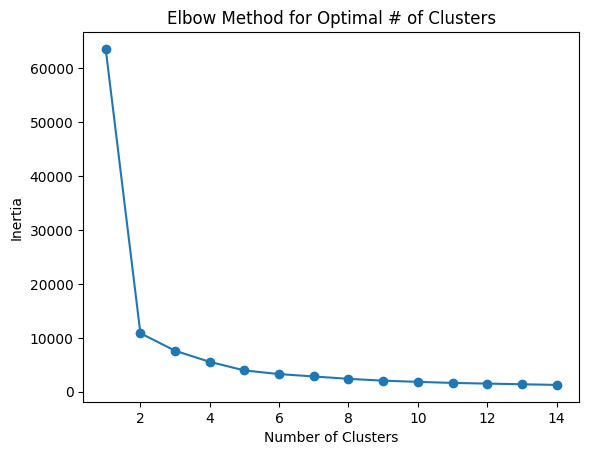

In [25]:
def build_clusters(player_df_clustering):
    inertia = []
    for k in range(1, 15):
        kmeans = KMeans(n_clusters = k, random_state = 0)
        kmeans.fit(player_df_clustering)
        inertia.append(kmeans.inertia_)

    plt.plot(range(1, 15), inertia, marker='o')
    plt.xlabel('Number of Clusters')
    plt.ylabel('Inertia')
    plt.title('Elbow Method for Optimal # of Clusters')
    plt.show()


/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.

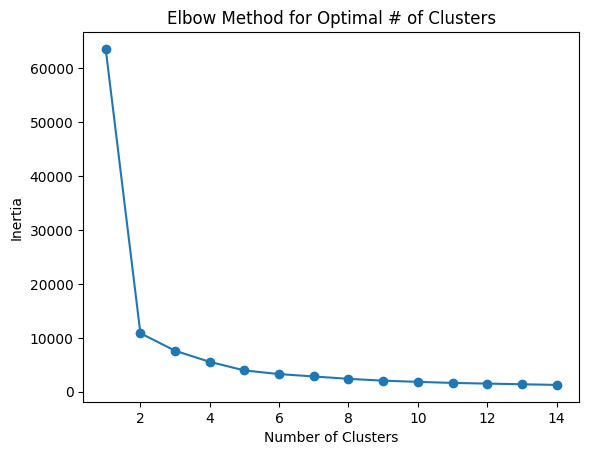

In [30]:
build_clusters(player_df_clustering)

/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/jp/h32thjnj7g9741ybp3j739th0000gn/T/ipykernel_14539/2918210212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['cluster'] = means.fit_predict(player_df_clustering)


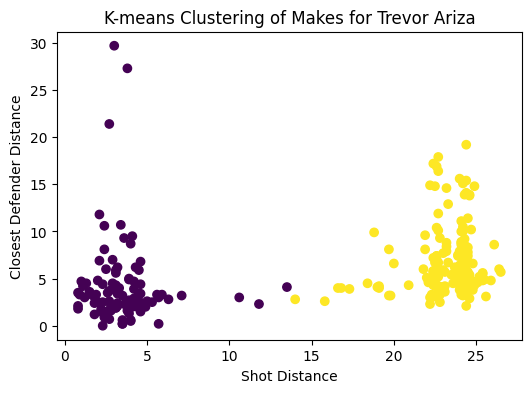

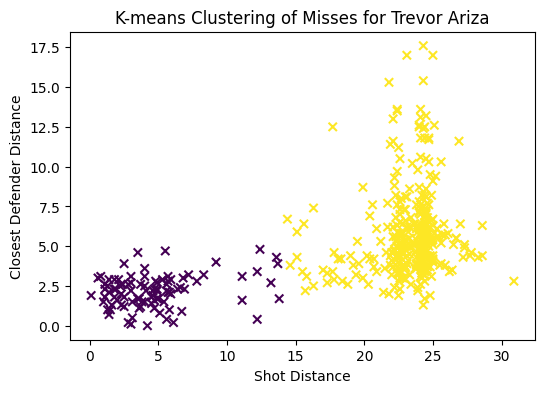

In [28]:
#EDIT NUM OF CLUSTERS DEPENDING ON GRAPH ABOVE
def k_means_clustering(player_df, num):
    means = KMeans(n_clusters=num, random_state=0)
    player_df['cluster'] = means.fit_predict(player_df_clustering)

    #splitting up makes and misses into different plots
    makes = player_df[player_df['SHOT_RESULT'] == 1]
    misses = player_df[player_df['SHOT_RESULT'] == 0]

    # Plotting for makes
    plt.figure(figsize=(6, 4))
    plt.scatter(makes['SHOT_DIST'], makes['CLOSE_DEF_DIST'], c=makes['cluster'], cmap='viridis')
    plt.xlabel('Shot Distance')
    plt.ylabel('Closest Defender Distance')
    plt.title('K-means Clustering of Makes for ' + string.capwords(player_name, sep=None))
    plt.show()

    # Plotting for misses
    plt.figure(figsize=(6, 4))
    plt.scatter(misses['SHOT_DIST'], misses['CLOSE_DEF_DIST'], c=misses['cluster'], marker='x', cmap='viridis')
    plt.xlabel('Shot Distance')
    plt.ylabel('Closest Defender Distance')
    plt.title('K-means Clustering of Misses for ' + string.capwords(player_name, sep=None))
    plt.show()

/Users/ericlee/Downloads/Projects/NBA-shotlog/myenv/lib/python3.8/site-packages/sklearn/cluster/_kmeans.py:1416: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)
/var/folders/jp/h32thjnj7g9741ybp3j739th0000gn/T/ipykernel_14539/2918210212.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  player_df['cluster'] = means.fit_predict(player_df_clustering)


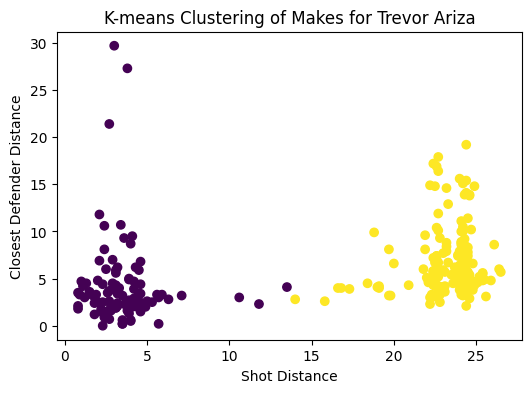

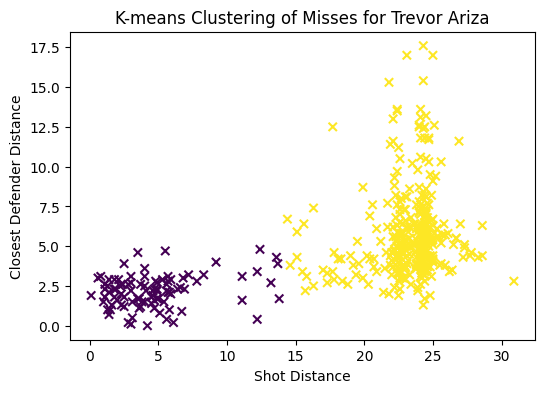

In [29]:
k_means_clustering(player_df, 2)

In [32]:
# Defender analysis
# Machine learning model to determine whether it can accurately decide whether a player will make a shot or not depending on the defender and proximity (contested shot within 5 ft)
# features: pts_type, closest_defender, closest_defender_distnace, shot_type
# output: shot_result

# isolate the defender based off user input (every shot where the closest defender is one person)
# determine a proper distance for what a contested shot is (5 ft)
# separate shots between close range, mid range, and 3 point
# eliminate any shot that is beyond half court (47 feet)

def defender_input():
    d_first = input("Please enter the defender's first name")
    d_last = input("Please enter the defender's last name")
    d_first = d_first.strip().lower().capitalize()
    d_last = d_last.strip().lower().capitalize()
    d_name = d_last + ", " + d_first
    d_df = df[df['CLOSEST_DEFENDER'] == d_name]
    d_df = d_df[d_df['CLOSE_DEF_DIST'] <= 4]
    #defender_df.head()

    #separate into paint, close range, midrange, 3pt

    d_df_paint = d_df[d_df['SHOT_DIST'] <= 8]
    d_df_paint = d_df[d_df['CLOSE_DEF_DIST'] <= 2]
    d_df_cr = d_df[d_df['SHOT_DIST'].between(8, 16)]
    d_df_mr = d_df[d_df['SHOT_DIST'].between(16, 24)]
    d_df_mr = d_df_mr[d_df_mr['PTS_TYPE'] == 2]
    d_df_3pt = d_df[d_df['PTS_TYPE'] == 3]
    return d_df, d_df_paint, d_df_mr, d_df_3pt



In [34]:
#get the defender's df where the only defender shown is the one input, and where the defender actually can affect the shot
d_df, d_df_paint, d_df_mr, d_df_3pt = defender_input()
d_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 221 entries, 2432 to 127214
Data columns (total 22 columns):
 #   Column                      Non-Null Count  Dtype  
---  ------                      --------------  -----  
 0   GAME_ID                     221 non-null    int64  
 1   MATCHUP                     221 non-null    object 
 2   LOCATION                    221 non-null    object 
 3   W                           221 non-null    object 
 4   FINAL_MARGIN                221 non-null    int64  
 5   SHOT_NUMBER                 221 non-null    int64  
 6   PERIOD                      221 non-null    int64  
 7   GAME_CLOCK                  221 non-null    object 
 8   SHOT_CLOCK                  214 non-null    object 
 9   DRIBBLES                    221 non-null    int64  
 10  TOUCH_TIME                  221 non-null    float64
 11  SHOT_DIST                   221 non-null    float64
 12  PTS_TYPE                    221 non-null    int64  
 13  SHOT_RESULT                 221 no

In [49]:
#decision tree classifier import
from sklearn.tree import DecisionTreeClassifier
from sklearn.model_selection import train_test_split
from sklearn import metrics

#random tree classifier
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score, confusion_matrix, precision_score, recall_score, ConfusionMatrixDisplay
from sklearn.model_selection import train_test_split


In [56]:
def dec_tree(d_df, feature_cols):
    X = d_df[feature_cols]
    y = d_df.SHOT_RESULT
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.25, random_state=1)
    clf = DecisionTreeClassifier()
    clf = clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)
    print("Accuracy: ", metrics.accuracy_score(y_test, y_pred))
    return y_test, y_pred
def rand_for(d_df, feature_cols):
    X_rf = d_df[feature_cols]
    y_rf = d_df.SHOT_RESULT
    X_train_rf, X_test_rf, y_train_rf, y_test_rf = train_test_split(X_rf, y_rf, test_size = 0.2)
    rf = RandomForestClassifier()
    rf.fit(X_train_rf, y_train_rf)
    y_pred_rf = rf.predict(X_test_rf)
    print("Accuracy: ", metrics.accuracy_score(y_test_rf, y_pred_rf))
    return y_test_rf, y_pred_rf

Accuracy:  0.44642857142857145
Accuracy:  0.7333333333333333


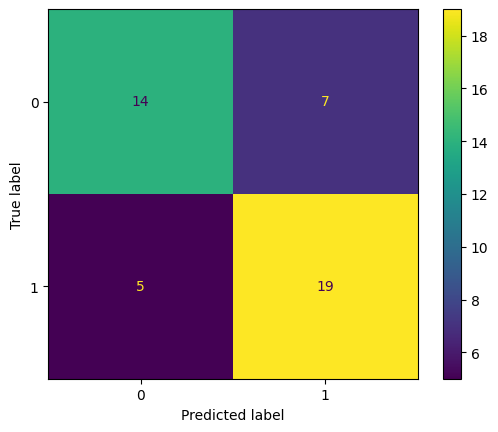

In [57]:
feature_cols = ['SHOT_DIST', 'CLOSE_DEF_DIST']
y_test, y_pred = dec_tree(d_df, feature_cols)
y_test_rf, y_pred_rf = rand_for(d_df, feature_cols)
cm = confusion_matrix(y_test_rf, y_pred_rf)
ConfusionMatrixDisplay(confusion_matrix=cm).plot()